# Predicting human motion using Hidden Markov Models (HMM)

Import the required libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

# import auxiliar modules.
import plotting as myplt
%matplotlib inline 

Load the clusters data with the previously computed clusters.

In [2]:
clusters = np.load("data/clusters.npy")

Let's plot the clusters.

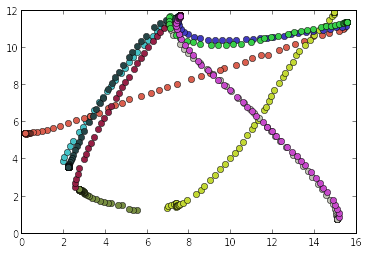

In [3]:
myplt.plot_time_model(clusters)

For efficiency reasons, we subsample the original clusters every two samples (0.6 seconds).

In [4]:
M, T, D = clusters.shape
new_t = int(np.ceil(T/3.0))
means = np.zeros((10, new_t, 2 ))
for m in xrange(M):
    for t in xrange(new_t):
        count = 0.0
        for fast_t in xrange(3 * t, min(3 *(t + 1), T)):
            means[m, t] += clusters[m, fast_t]
            count += 1.0
        means[m, t] /= count

And we plot the resulting model.

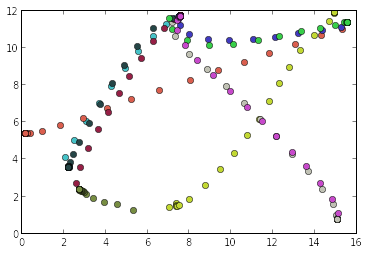

In [5]:
myplt.plot_time_model(means)

# A Hidden Markov Model (HMM)

A discrete version of the Bayes Filter.

+ Variables:
  - The previous state: $S_{t-1}$
  - The current state: $S_t$
  - Observation: $O \epsilon R^2$
<br/><br/>
+ A Joint Probability Function:<br/>

$$P(S_{t-1}, S_t, O_t) = P(S_{t-1})P(S_t | S_{t-1})P(O_t | S_t)$$


Now, we will fill the parameters for the different probability distributions. We start with transition probabilities.

$$P([S_t=i]|[S_{t-1}=j]) \rightarrow A_{ij}$$

In [6]:
# Fill in transition probabilities

a = np.zeros( ( M, new_t, new_t ) )
for m in xrange( M ):
    for t in xrange( new_t ):
        if t < new_t - 1:
            # Normal node
            a[m, t, t + 1] = 1. / 3. # Advance
            a[m, t, t] = 2. / 3.     # Stay in node
        else:
            # End node
            a[m, t, t] = 1.

Now, the previous state.


$$P[S_{t-1}=i]) \rightarrow \pi_{i}$$

In [7]:
# Fill in priors
pi = np.zeros( ( M, new_t ) )

for m in xrange( M ):
    pi[m, 0] = 1.0

pi /= np.sum( pi )

Finally, we set the global covariance for the observation probabilities.

In [8]:
covariance = np.array( [[4.0, 0.0], [0.0, 4.0]] )
cov_inv = np.linalg.inv( covariance )

# Using the model for prediction

Let's use the last 100 trajectories as test data (observations).

In [9]:
data = np.load("data/tjcs.npy")
test_data = data[-100:]

We will first implement the filtering algorithm:

$$P([S_t=i]|O_{1:T}) = \frac{1}{Z} P(O_t|(S_t =i)) \sum_{j=1}^{N} P([S_t=1]|[S_{t-1}=j])P([S_{t-1}=j]|O_{1:t-1})$$

In [10]:
def filter( belief, a, means, cov_inv, obs, t ):
    M, new_t = belief.shape
    current = np.zeros( ( M, new_t ) )
    for m in xrange( M ):
        for i in xrange( new_t ):
            for old_t in xrange( new_t ):
                diff = means[m, i] - obs[t]
                expo = -0.5 * np.dot( np.dot( diff, cov_inv ), diff.transpose() )
                current[m, i] += belief[m, old_t] * a[m, old_t, i] * exp( expo ) 
    current /= np.sum( current )
    belief[:] = current[:]

And now the prediction one:

$$P([S_{t+H}=i]|O_{1:t})=\sum_{j=1}^{N} P([S_{t+H}=i]|[S_{t+H-1}=j]) P([S_{t+H-1}=j]|O_{1:t})$$

In [11]:
def predict( belief, a, steps ):
    M, new_t = belief.shape
    for t in xrange( steps ):
        current = np.zeros( ( M, new_t ) )
        for m in xrange( M ):
            for i in xrange( new_t ):
                for old_t in xrange( new_t ):
                    current[m, i] += belief[m, old_t] * a[m, old_t, i]
        current /= np.sum( current )
        belief = current
    return belief

Use tjcs 34 to 36 as observations. 

T = 0


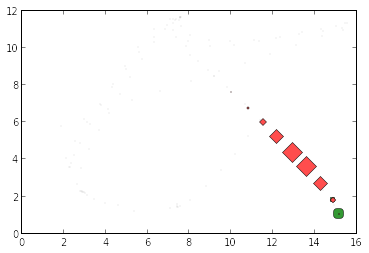

T = 2


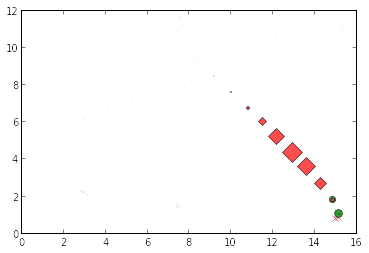

T = 4


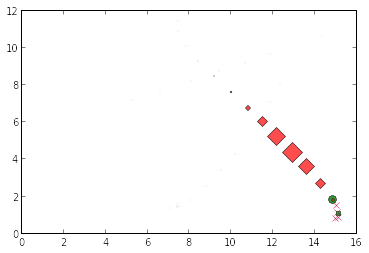

T = 6


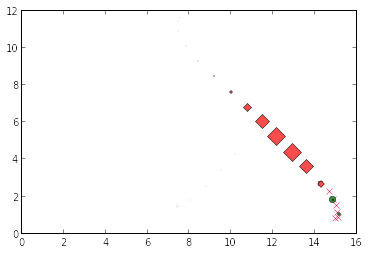

T = 8


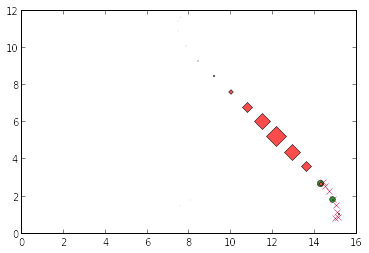

T = 10


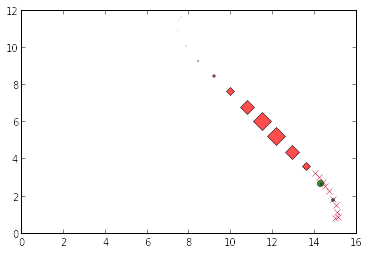

T = 12


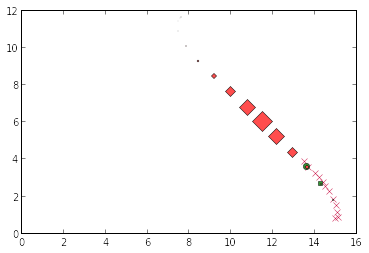

T = 14


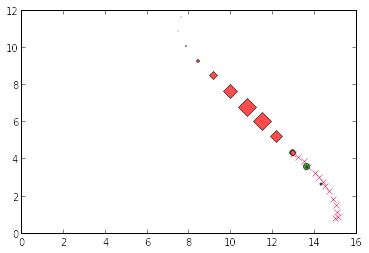

T = 16


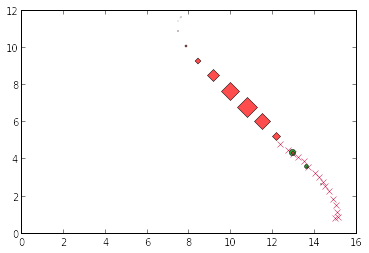

T = 18


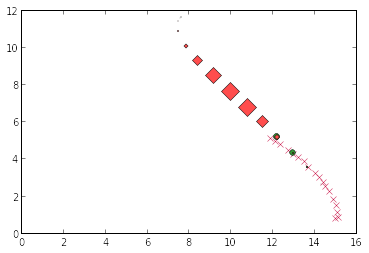

T = 0


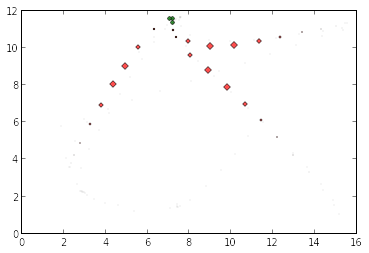

T = 2


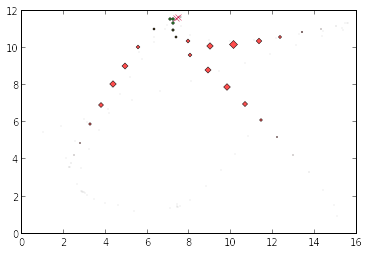

T = 4


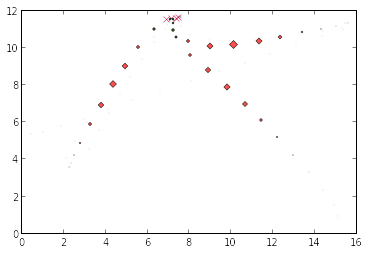

T = 6


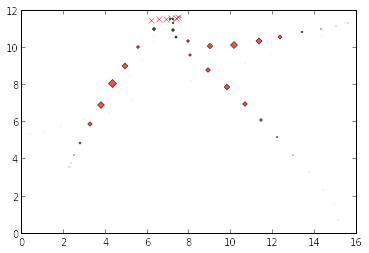

T = 8


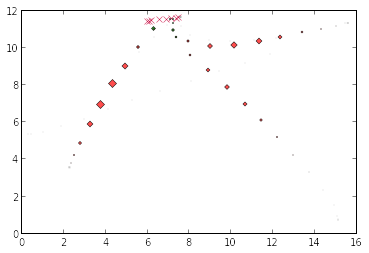

T = 10


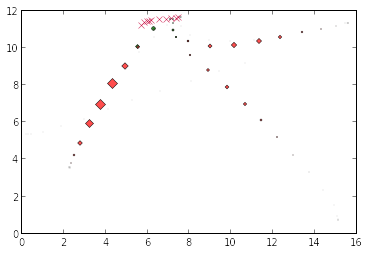

T = 12


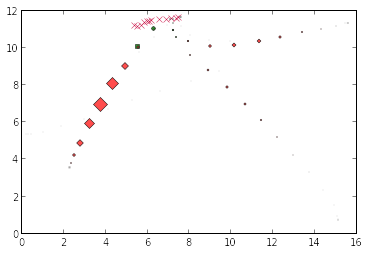

T = 14


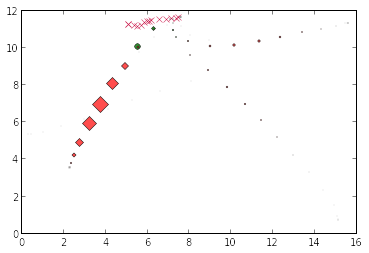

T = 16


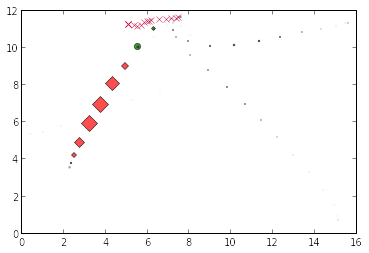

T = 18


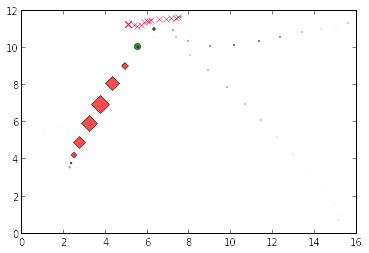

T = 0


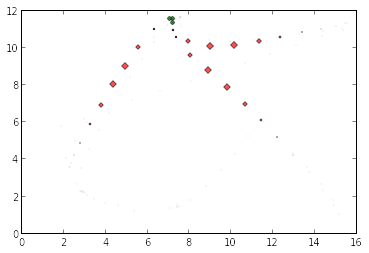

T = 2


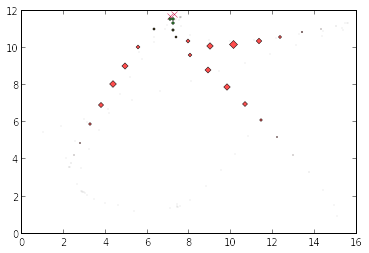

T = 4


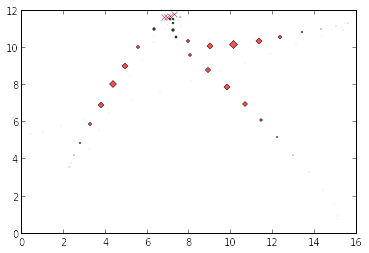

T = 6


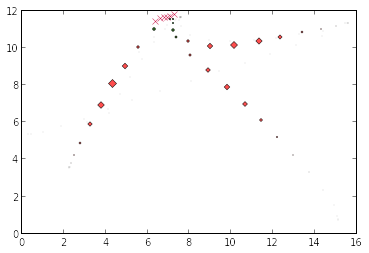

T = 8


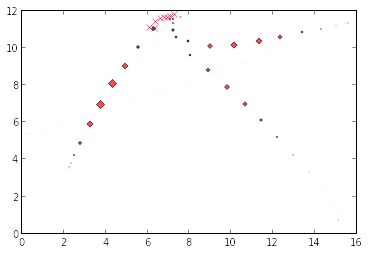

T = 10


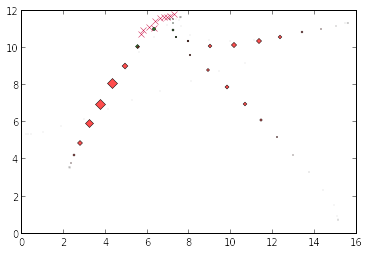

T = 12


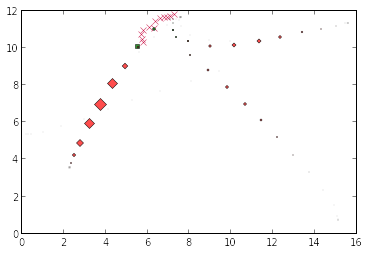

T = 14


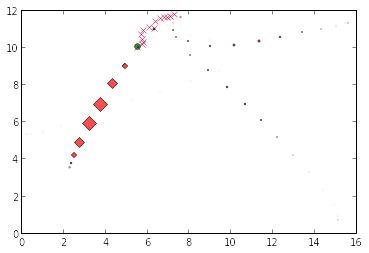

T = 16


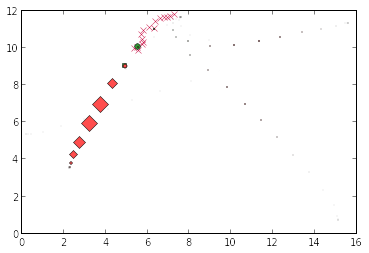

T = 18


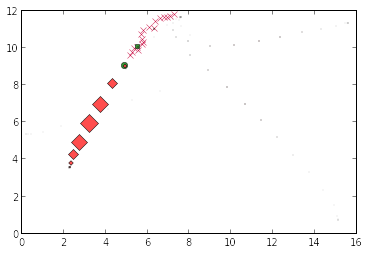

In [12]:
for obs in test_data[34:37]:
    belief = pi.copy()
    for t in xrange( 0, 20, 2 ):
        filter( belief, a, means, cov_inv, obs, t )
        prediction = predict( belief, a, 10 )
        myplt.plot_prediction( means, obs[:t], belief, prediction )        
        print "T = %i" % ( t, )
        plt.show()